In [1]:
from utils.models import *

In [2]:
env()

--------- Dependencies ---------
python: 3.8.10 | packaged by conda-forge | (default, May 11 2021, 06:25:23) [MSC v.1916 64 bit (AMD64)]
numpy: 1.21.0
pandas: 1.2.4
matplotlib: 3.4.2
scipy: 1.7.1
statsmodels: 0.13.0


## VIX

In [3]:
wti = load('data/WTI.csv').pct_change().dropna()
c1 = clean_series('contract_1', wti)
vix = load('data/VIX.csv')
vix_shock = calc_shock('VIX', vix)

In [4]:
window = 60 # number of months for measurement sample (lags mean only 24 datapoints available for each sample)
conf_int = .1 # confidence interval (2-tailed, Student's t)
lags = 3
kalman = KF(window=window, conf_int=conf_int, lags=lags)
kf, confs = kalman.run('contract_1', 'VIX', c1.join(vix_shock).dropna())

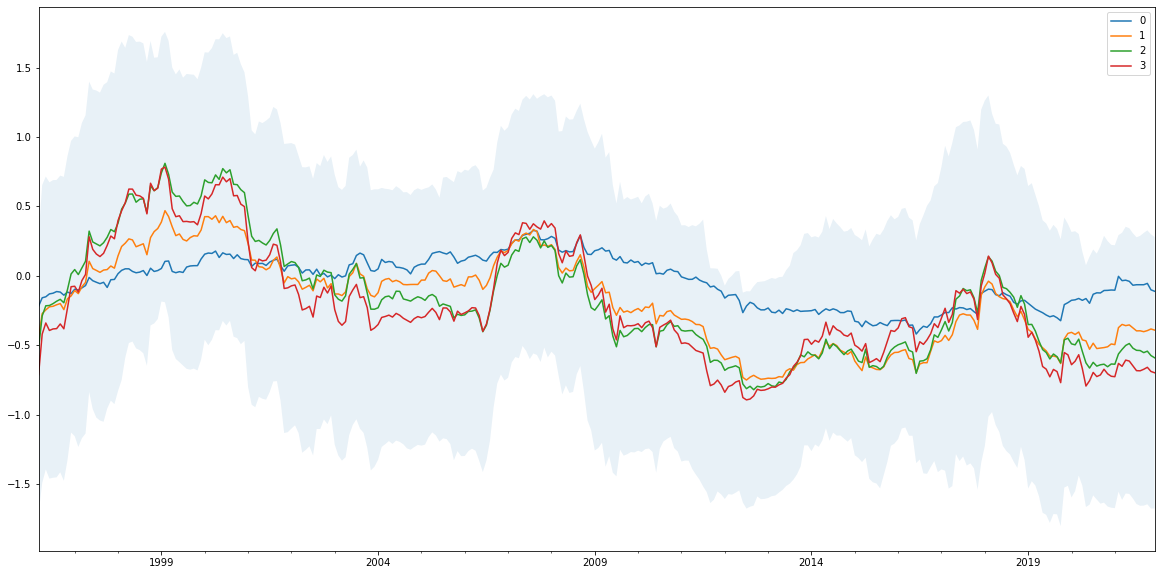

In [5]:
kf.plot(figsize=(20,10))
plt.fill_between(confs.index, confs['lower'], confs['upper'], alpha=0.1)

In [6]:
confs[confs['lower'] > 0] # significant upward movements

,lower,upper


In [7]:
confs[confs['upper'] < 0] # significant downward movements

,lower,upper
2012-01-01,-1.606727,-0.070238
2012-02-01,-1.571963,-0.022161
2012-06-01,-1.631894,-0.120928
2012-07-01,-1.675747,-0.110793
2012-08-01,-1.662682,-0.111977
2012-09-01,-1.654651,-0.074554
2012-10-01,-1.588983,-0.045145
2012-11-01,-1.608097,-0.041824
2012-12-01,-1.606563,-0.038338
2013-01-01,-1.599774,-0.027304


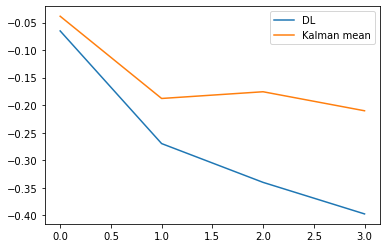

In [8]:
dl = DL('contract_1', 'VIX', c1.join(vix_shock).dropna().iloc[window-lags:], lags=lags)
plt.plot(np.cumsum(dl.model.params[1:]), label='DL')
plt.plot(kf.mean(), label='Kalman mean')
plt.legend()

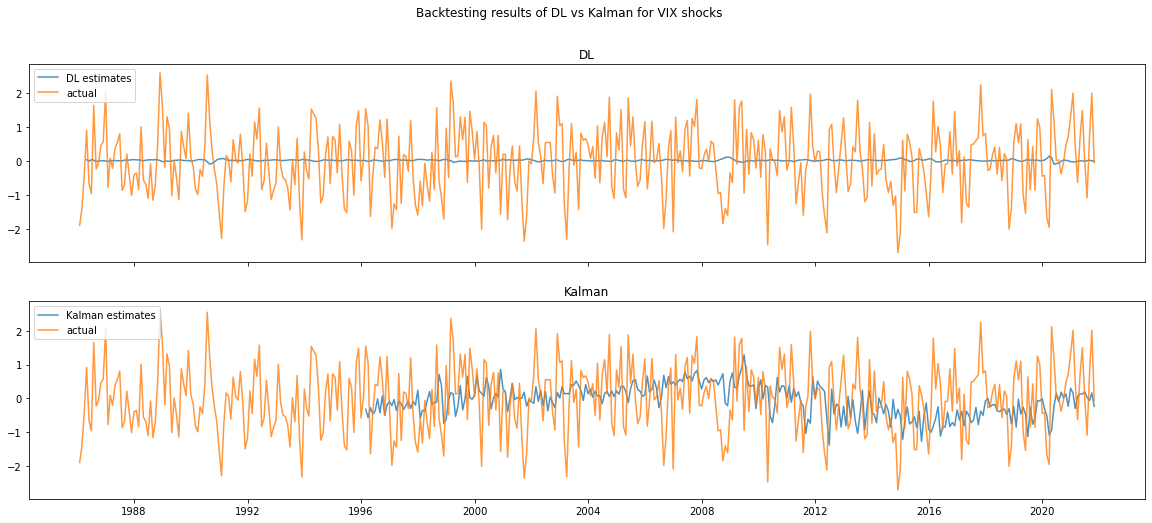

In [9]:
kalman_backtest = kalman.backtest()

x = wti.contract_1
dl_backtest = dl.model.params[0] + x * dl.model.params[1]
for i in range(2, lags+2): # remember params contain constant at [0]
    dl_backtest += x.shift(i-1) * dl.model.params[i]

fig, ax = plt.subplots(2, sharex=True, figsize=(20,8))
fig.suptitle('Backtesting results of DL vs Kalman for VIX shocks')
ax[0].plot(dl_backtest, label='DL estimates', alpha=0.8)
ax[0].plot(c1.contract_1, label='actual', alpha=0.8)
ax[0].set_title('DL')
ax[0].legend()
ax[1].plot(kalman_backtest, label='Kalman estimates', alpha=0.8)
ax[1].plot(c1.contract_1, label='actual', alpha=0.8)
ax[1].set_title('Kalman')
ax[1].legend()

In [10]:
rmse_dl = np.sqrt(np.sum((x.loc[min(dl_backtest.index):] - dl_backtest) ** 2) / len(dl_backtest))
rmse_kalman = np.sqrt(np.sum((x.loc[min(kalman_backtest.index):] - kalman_backtest) ** 2) / len(kalman_backtest))
print(f'RMSE DL: {rmse_dl}')
print(f'RMSE Kalman: {rmse_kalman}')

RMSE DL: 0.10883975859406426
RMSE Kalman: 0.46685039017581115


## GPR

In [11]:
gpr = load('data/GPRGlobal.csv')
gpr_shock = calc_shock('GPRI', gpr)

In [12]:
kf2, confs2 = kalman.run('contract_1', 'GPRI', c1.join(gpr_shock).dropna())

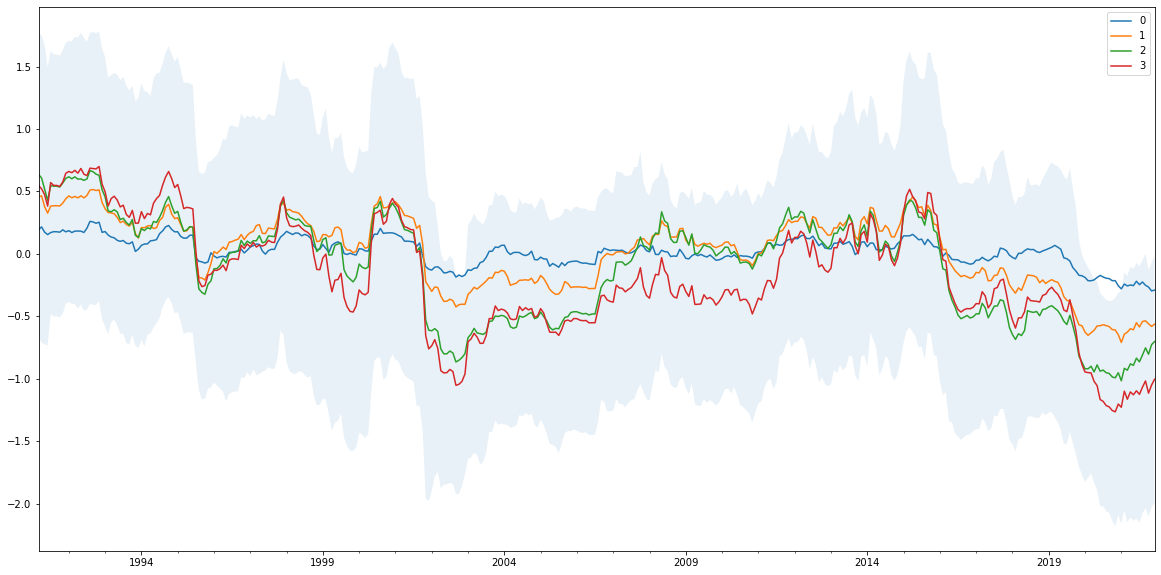

In [13]:
kf2.plot(figsize=(20, 10))
plt.fill_between(confs2.index, confs2['lower'], confs2['upper'], alpha=0.1)

In [14]:
confs2[confs2['lower'] > 0]

,lower,upper


In [15]:
confs2[confs2['upper'] < 0]

,lower,upper
2002-05-01,-1.844351,-0.059741
2002-06-01,-1.843737,-0.055223
2002-07-01,-1.832268,-0.015633
2002-08-01,-1.839842,-0.041803
2002-09-01,-1.920169,-0.182394
2002-10-01,-1.918812,-0.166479
2002-11-01,-1.855632,-0.182728
2002-12-01,-1.763934,-0.155083
2019-12-01,-1.768765,-0.004380
2020-01-01,-1.825358,-0.063218


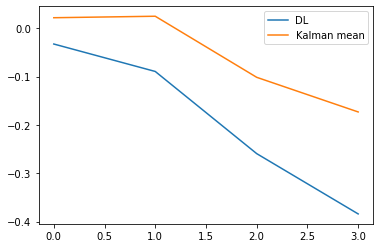

In [16]:
dl2 = DL('contract_1', 'GPRI', c1.join(gpr_shock).dropna().iloc[window-lags:], lags=lags)
plt.plot(np.cumsum(dl2.model.params[1:]), label='DL')
plt.plot(kf2.mean(), label='Kalman mean')
plt.legend()

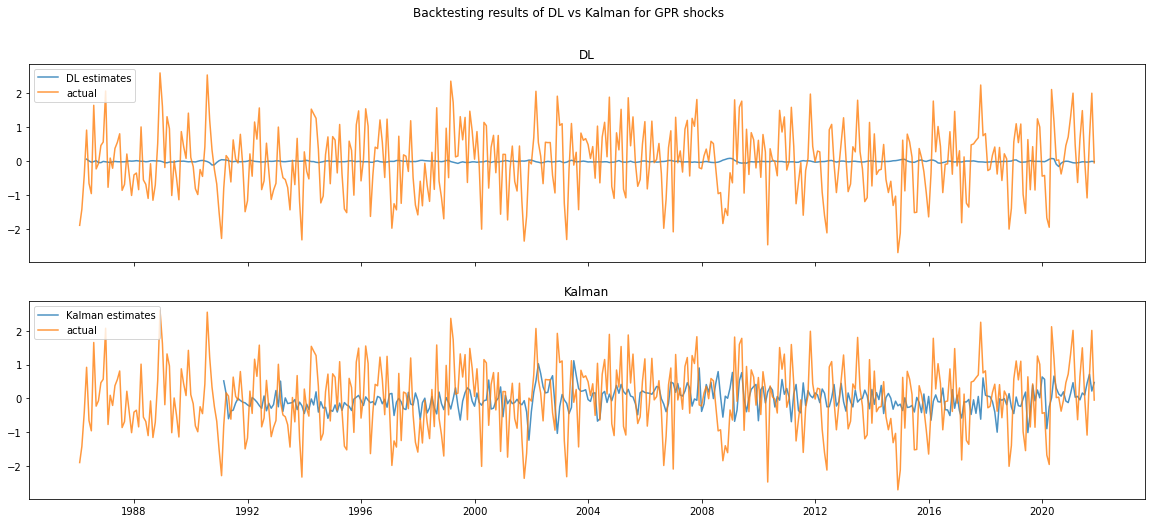

In [17]:
kalman_backtest2 = kalman.backtest()

dl_backtest2 = dl2.model.params[0] + x * dl2.model.params[1]
for i in range(2, lags+2): # remember params contain constant at [0]
    dl_backtest2 += x.shift(i-1) * dl2.model.params[i]

fig, ax = plt.subplots(2, sharex=True, figsize=(20,8))
fig.suptitle('Backtesting results of DL vs Kalman for GPR shocks')
ax[0].plot(dl_backtest2, label='DL estimates', alpha=0.8)
ax[0].plot(c1.contract_1, label='actual', alpha=0.8)
ax[0].set_title('DL')
ax[0].legend()
ax[1].plot(kalman_backtest2, label='Kalman estimates', alpha=0.8)
ax[1].plot(c1.contract_1, label='actual', alpha=0.8)
ax[1].set_title('Kalman')
ax[1].legend()

In [18]:
rmse_dl2 = np.sqrt(np.sum((x.loc[min(dl_backtest2.index):] - dl_backtest2) ** 2) / len(dl_backtest2))
rmse_kalman2 = np.sqrt(np.sum((x.loc[min(kalman_backtest2.index):] - kalman_backtest2) ** 2) / len(kalman_backtest2))
print(f'RMSE DL: {rmse_dl2}')
print(f'RMSE Kalman: {rmse_kalman2}')

RMSE DL: 0.10162397368983375
RMSE Kalman: 0.3339770012329785
